In [6]:
import os
import numpy as np
import cv2
import torch
import random
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
from totalface_cpu.model_zoo.get_models import get_detection_model
from totalface_cpu.face.get_result import get_detection

from totalface_cpu.utils.util_warp import face_align
from totalface_cpu.data.constant import LMARK_REF_ARC

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/_vendor/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


In [4]:
from src.model import build_model
from src.get_config import get_config

In [5]:
def normalization(rgb_img,mean_list=[0.485, 0.456, 0.406],std_list=[0.229, 0.224, 0.225]):
    MEAN = 255 * np.array(mean_list)
    STD = 255 * np.array(std_list)
    rgb_img = rgb_img.transpose(-1, 0, 1)
    norm_img = (rgb_img - MEAN[:, None, None]) / STD[:, None, None]
    
    return norm_img

def align(img,land,ref_land,input_size=224):
    aimg = face_align(img,ref_land,land,input_size)
    return aimg

def preprocessing(aimg,mean_list=[0.485, 0.456, 0.406],std_list=[0.229, 0.224, 0.225]):
    input_img = normalization(aimg,mean_list,std_list) # aimg is RGB
    input_img = torch.tensor(np.expand_dims(input_img,0).astype(np.float32))
    
    return input_img

In [125]:
# load config
cfg_path = "configs/efficientNet_B0_celebA.py"
#cfg_path = "configs/efficientNet_B0_celebA_add.py"
cfg = get_config(cfg_path)

In [126]:
attribute_names = cfg.attribute_names

In [127]:
if 'add' in cfg_path:
    ori_size=112
    new_size=cfg.input_size
    add_size=(new_size-ori_size)//2
    ref_land = LMARK_REF_ARC+[add_size,add_size]
else:
    if cfg.input_size==224:
        ref_land = LMARK_REF_ARC*2
    elif cfg.input_size==112:
        ref_land = LMARK_REF_ARC

In [128]:
# load model
model_path = "./save_model_224/best_epoch28.pth"
#model_path = "./save_model_add224/best_epoch30.pth"

model = build_model(cfg.network,cfg.num_classes,'',False)

load_weight = torch.load(model_path)
new_state_dict = OrderedDict()
for n, v in load_weight.items():
    name = n.replace("module.","") 
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)
_ = model.eval()

In [130]:
# detection model for align
detection_path = "detection/scrfd_10g_bnkps.onnx"
detection_name = "scrfd"
# Set parameters
detection_thresh = 0.5
detection_height_min=0 
detection_model = get_detection_model(detection_name,detection_path,load_multi=False)

providers: ['CPUExecutionProvider']
scrfd onnx loaded


In [385]:
base = "celebA/csv/230720/celebA_anno_mixed10000_test.csv"
#base = "/data/shared/Face/FaceExpression/datasets/celebA/csv/230720/check_celebA.csv"
image_base = "celebA/Img/img_celeba/"
df = pd.read_csv(base)

In [388]:
for val in df.values:
    if '00128' in val[0]:
        choice_path = os.path.join(image_base,val[0])
        break

In [389]:
print(choice_path)
print(classes_gt)

/data/shared/Face/FaceExpression/datasets/celebA/Img/img_celeba/100128.jpg
{'Beard': 0, 'Smiling': 0, 'Eyeglasses': 0, 'Wearing_Lipstick': 0, 'Wearing_Hat': 0, 'Wearing_Earrings': 0, 'Wearing_Necklace': 0}


In [390]:
# detect and align
img = cv2.cvtColor(cv2.imread(choice_path),cv2.COLOR_BGR2RGB)
faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh,height_min=detection_height_min,input_size=(640,640))

if len(faces)<1:
    print("not detected")
elif len(faces)==1:
    face = faces[0]
else:
    for face in faces:
        if face.max_flag:
            break
            
land = face.land5
    
aimg = align(img,land,ref_land,cfg.input_size)

In [391]:
input_img = preprocessing(aimg)

out = model(input_img)
out = out[0].detach().numpy()

In [392]:
classes = {}

for ki,k in enumerate(attribute_names):
    classes[k]=out[ki]

In [393]:
# draw

In [394]:
threshold = 0.5

In [395]:
dimg = img.copy()
bbox = face.bbox.astype(np.int32)
dimg = cv2.rectangle(dimg,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),2)

height,width,_ = dimg.shape
x1y1 = (int(bbox[0] * height / dimg.shape[0]), int(bbox[1] * width / dimg.shape[1]))
x2y2 = (int((bbox[0] + bbox[2]) * height / dimg.shape[0]), int((bbox[1] + bbox[3]) * width / dimg.shape[1]))
y_txt1 = 10
y_txt2 = 5
color = (0, 255, 255)

        
for key in classes:
    # If the probability of a class is more than the threshold then it will be set with its appropriate label
    if classes[key] > threshold:
        text = '{} {:.1%}'.format(key, classes[key])
        print(text)
        dimg = cv2.rectangle(dimg, (x1y1[0], x1y1[1] - y_txt1 - 11), (x1y1[0] + (len(key) * 8) + 60, x1y1[1] - y_txt2), color, -1)
        dimg = cv2.putText(dimg, text, (x1y1[0] + 5, x1y1[1] - y_txt1), cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 0, 0), 1)
        y_txt1 += 20
        y_txt2 += 20

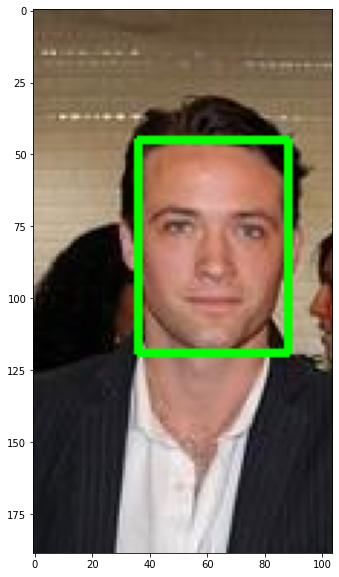

In [396]:
plt.figure(figsize=(10,10))
plt.imshow(dimg)

In [ ]:
# aligned 배경 포함해야 하는 경우
# 000128.jpg - hat
# 000308.jpg - smiling false (224)

In [131]:
# false check

In [317]:
hf_path = "celebA/h5/230720/celeba_224_test.h5"
#hf_path = "celebA/h5/230720/celeba_add_224_test.h5"
hf = h5py.File(hf_path,'r')
images = hf['images']
labels = hf['labels']

In [318]:
label_keys = [lb.decode('utf-8') for lb in list(hf['label_list'])]
print(label_keys)

['Beard', 'Smiling', 'Eyeglasses', 'Wearing_Lipstick', 'Wearing_Hat', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie']


In [319]:
npath = "./save_model_224/false_dict.npy"
false_dict = np.load(npath,allow_pickle=True)
false_dict = false_dict.item()

In [320]:
false_dict.keys()

dict_keys(['Beard', 'Smiling', 'Eyeglasses', 'Wearing_Lipstick', 'Wearing_Hat', 'Wearing_Earrings', 'Wearing_Necklace', 'Wearing_Necktie'])

In [321]:
flist = false_dict['Wearing_Hat']
fidx = 4

In [334]:
choice = random.choice(flist)
p = choice[0]
img = images[choice[1]]

In [335]:
print(choice)

[0.74308634, 12145]


In [346]:
input_img = preprocessing(img)

out = model(input_img)
out = out[0].detach().numpy()

In [347]:
out[fidx],p

(0.6364917, 0.74308634)